In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tqdm.notebook import tqdm


In [8]:
data = pd.read_csv("../../../data/class_credit_score.csv")
data = data.select_dtypes(include='number')

In [9]:
standard_scaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(data)
min_max_scaler = MinMaxScaler(feature_range=(0,1), copy=True).fit(data)

In [17]:
data_standard_scaled = pd.DataFrame(standard_scaler.transform(data), index=data.index)
data_min_max_scaled = pd.DataFrame(min_max_scaler.transform(data), index=data.index)

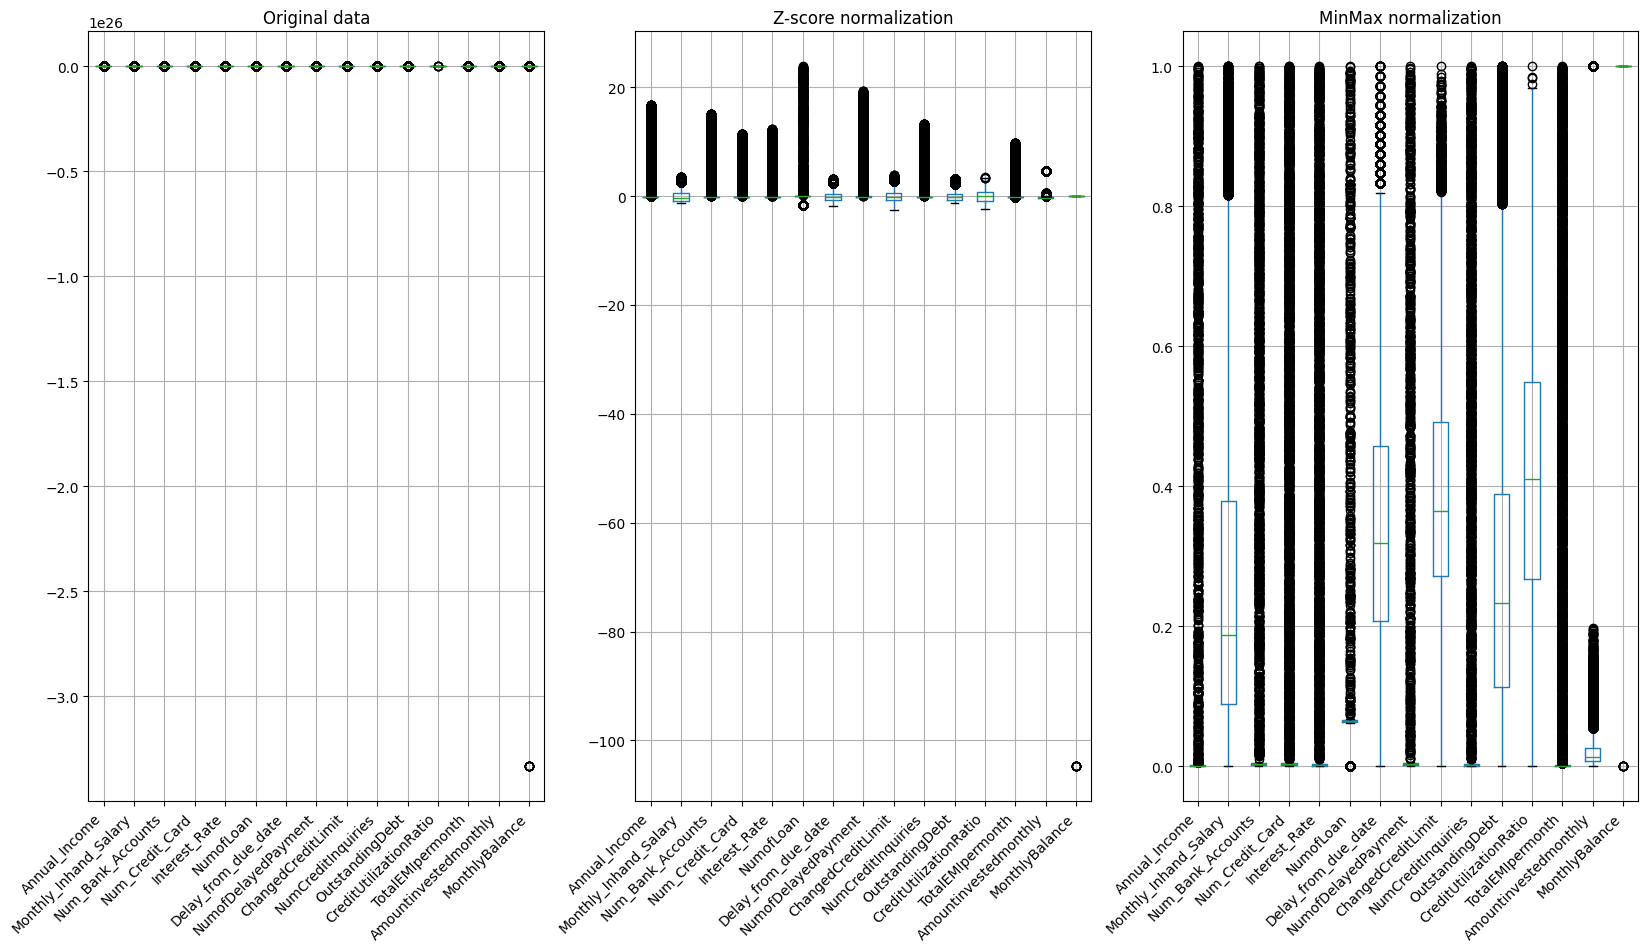

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10), squeeze=False)

axs[0, 0].set_title("Original data")
data.boxplot(ax=axs[0, 0])
axs[0, 0].set_xticklabels(data.columns.to_list(), rotation=45, ha='right')

axs[0, 1].set_title("Z-score normalization")
data_standard_scaled.boxplot(ax=axs[0, 1])
axs[0, 1].set_xticklabels(data.columns.to_list(), rotation=45, ha='right')

axs[0, 2].set_title("MinMax normalization")
data_min_max_scaled.boxplot(ax=axs[0, 2])
axs[0, 2].set_xticklabels(data.columns.to_list(), rotation=45, ha='right')

plt.savefig(f"images/service_scaling.png")